# Speech Emotion Recognition With Convolutional Neural Network

<H2>Import Libraries<H2>

In [1]:

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
import resampy
import lazy
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Importing the necessary Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, BatchNormalization, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
TESS = "D:\data\Tess"
RAV =r'D:\data\Ravdess\audio_speech_actors_01-24'
SAVEE = "D:\data\Savee"
CREMA = "D:\data\Crema"

# Run one example 
dir_list = os.listdir(SAVEE)
dir_list[0:5]

['DC_a01.wav', 'DC_a02.wav', 'DC_a03.wav', 'DC_a04.wav', 'DC_a05.wav']

<h2>Analysis of 4 Datasets<h2>

In [3]:
dir_list = os.listdir(SAVEE)
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(os.path.join(SAVEE, i))
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df[50:60]

labels source                      path
50  male_happy  SAVEE  D:\data\Savee\DC_h06.wav
51  male_happy  SAVEE  D:\data\Savee\DC_h07.wav
52  male_happy  SAVEE  D:\data\Savee\DC_h08.wav
53  male_happy  SAVEE  D:\data\Savee\DC_h09.wav
54  male_happy  SAVEE  D:\data\Savee\DC_h10.wav
55  male_happy  SAVEE  D:\data\Savee\DC_h11.wav
56  male_happy  SAVEE  D:\data\Savee\DC_h12.wav
57  male_happy  SAVEE  D:\data\Savee\DC_h13.wav
58  male_happy  SAVEE  D:\data\Savee\DC_h14.wav
59  male_happy  SAVEE  D:\data\Savee\DC_h15.wav

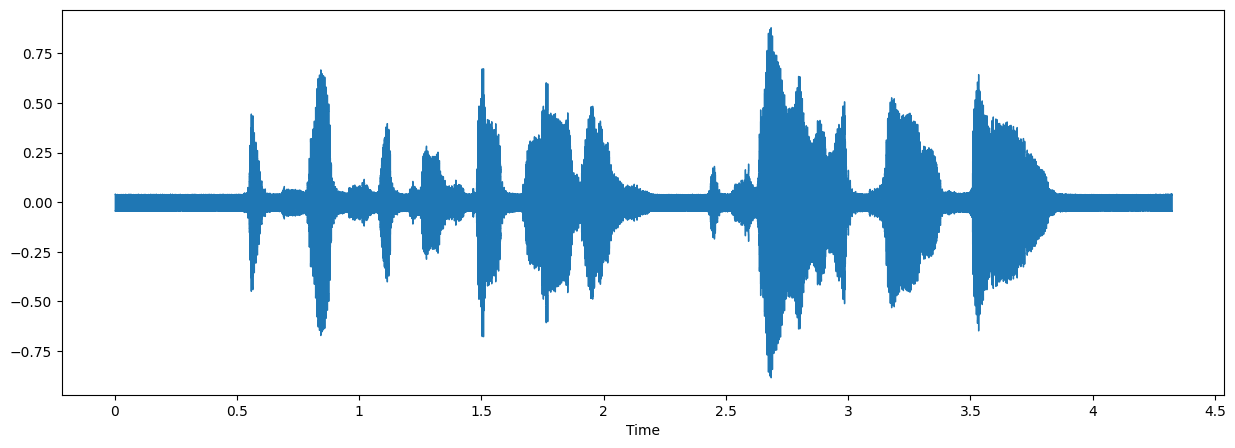

In [4]:
fname = "D:\data\Savee\DC_f11.wav"  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

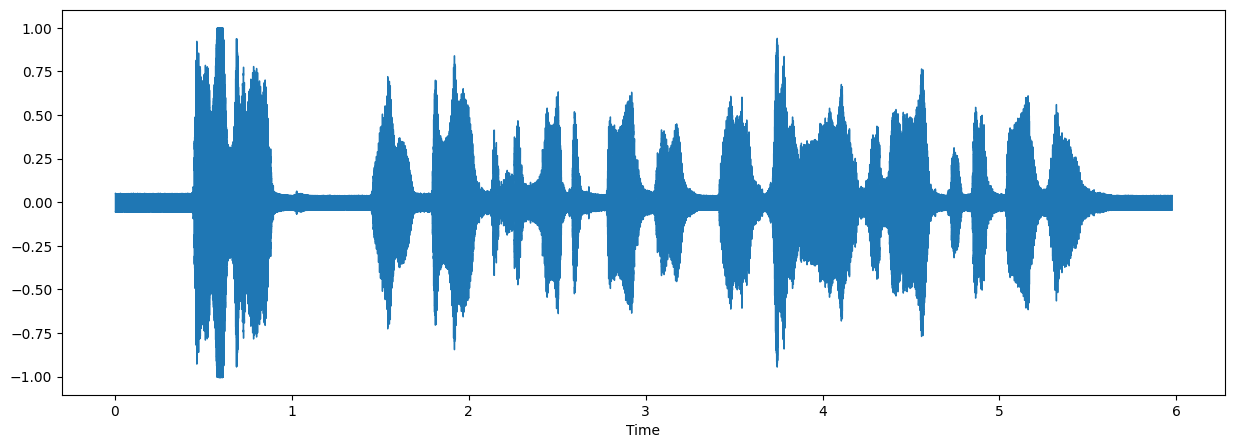

In [5]:
fname = 'D:\data\Savee\DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [6]:
emotion = []
gender = []
path = []
RAV = 'D:\\data\\Ravdess\\audio_speech_actors_01-24\\'  # Ensure the path ends with a separator
dir_list = ['Actor_01', 'Actor_02', 'Actor_03','Actor_04','Actor_05','Actor_06','Actor_07','Actor_08','Actor_09',
            'Actor_10','Actor_11','Actor_12','Actor_13','Actor_14','Actor_15','Actor_16','Actor_17','Actor_18',
            'Actor_19','Actor_20','Actor_21','Actor_22','Actor_23','Actor_24']  #Add relevant directories

for i in dir_list:
    full_dir_path = os.path.join(RAV, i)  # Safely join paths
    try:
        fname = os.listdir(full_dir_path)
        for f in fname:
            part = f.split('.')[0].split('-')
            emotion.append(int(part[2]))
            temp = int(part[6])
            gender.append("female" if temp % 2 == 0 else "male")
            file_path = os.path.join(full_dir_path, f)  # Safely join full path to file
            path.append(file_path)
    except FileNotFoundError as e:
        print(f"Directory not found: {full_dir_path}")

# Create DataFrame and map emotion labels
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1: 'neutral', 2: 'neutral', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'})

# Add gender and file paths
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']

# Combine gender and emotion for labels
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'

# Add file paths to the DataFrame
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)

# Drop unnecessary columns
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

# Display value counts for labels
RAV_df.head()

labels   source                                               path
0  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
1  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
2  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
3  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...
4  male_neutral  RAVDESS  D:\data\Ravdess\audio_speech_actors_01-24\Acto...

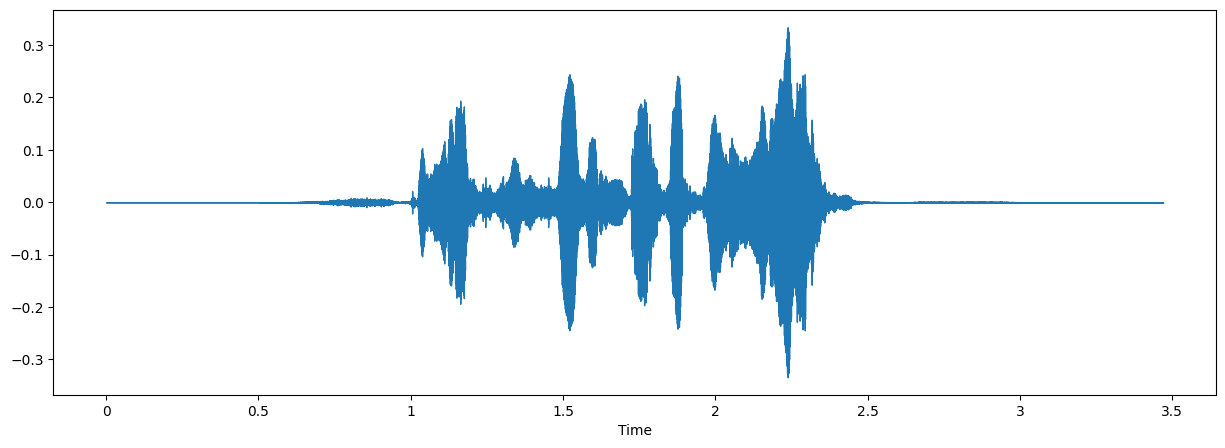

In [7]:
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

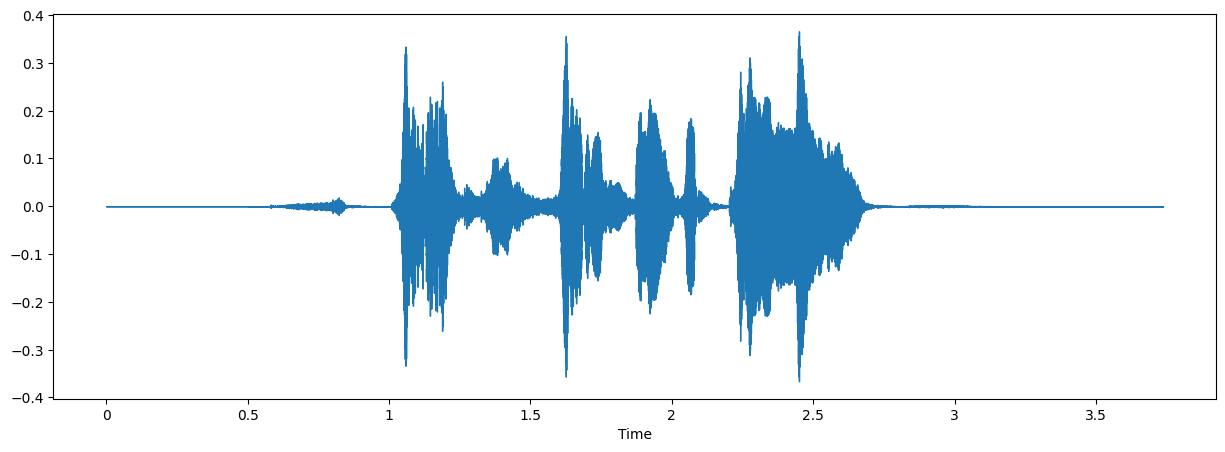

In [8]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [9]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [10]:
emotion = []
path= []

# List of directories to process
dir_list = ['OAF_angry', 'YAF_angry', 'OAF_disgust', 'YAF_disgust', 'OAF_fear', 'YAF_fear',
            'OAF_happy', 'YAF_happy', 'OAF_neutral', 'YAF_neutral', 'OAF_pleasant_surprise',
            'YAF_pleasant_surprise', 'OAF_sad', 'YAF_sad']

# Emotion mapping dictionary
emotion_mapping = {
    'OAF_angry': 'female_angry', 'YAF_angry': 'female_angry',
    'OAF_disgust': 'female_disgust', 'YAF_disgust': 'female_disgust',
    'OAF_fear': 'female_fear', 'YAF_fear': 'female_fear',
    'OAF_happy': 'female_happy', 'YAF_happy': 'female_happy',
    'OAF_neutral': 'female_neutral', 'YAF_neutral': 'female_neutral',
    'OAF_pleasant_surprise': 'female_surprise', 'YAF_pleasant_surprise': 'female_surprise',
    'OAF_sad': 'female_sad', 'YAF_sad': 'female_sad'
}

# Process each directory
for i in dir_list:
    full_dir_path = os.path.join(TESS, i)  # Safely join paths
    try:
        fname = os.listdir(full_dir_path)
        for f in fname:
            emotion.append(emotion_mapping.get(i, 'Unknown'))  
            
            path.append(os.path.join(full_dir_path, f))  
    except FileNotFoundError as e:
        print(f"Directory not found: {full_dir_path}")

# Create DataFrame from the lists
TESS_df = pd.DataFrame(emotion, columns=['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df, pd.DataFrame(path, columns=['path'])], axis=1)

# Display value counts for labels
print(TESS_df.labels.value_counts())
TESS_df


Directory not found: D:\data\Tess\YAF_pleasant_surprise
female_angry       400
female_disgust     400
female_fear        400
female_happy       400
female_neutral     400
female_sad         212
female_surprise    200
Name: labels, dtype: int64


labels source                                       path
0     female_angry   TESS  D:\data\Tess\OAF_angry\OAF_back_angry.wav
1     female_angry   TESS   D:\data\Tess\OAF_angry\OAF_bar_angry.wav
2     female_angry   TESS  D:\data\Tess\OAF_angry\OAF_base_angry.wav
3     female_angry   TESS  D:\data\Tess\OAF_angry\OAF_bath_angry.wav
4     female_angry   TESS  D:\data\Tess\OAF_angry\OAF_bean_angry.wav
...            ...    ...                                        ...
2407    female_sad   TESS      D:\data\Tess\YAF_sad\YAF_boat_sad.wav
2408    female_sad   TESS      D:\data\Tess\YAF_sad\YAF_bone_sad.wav
2409    female_sad   TESS      D:\data\Tess\YAF_sad\YAF_book_sad.wav
2410    female_sad   TESS    D:\data\Tess\YAF_sad\YAF_bought_sad.wav
2411    female_sad   TESS      D:\data\Tess\YAF_sad\YAF_burn_sad.wav

[2412 rows x 3 columns]

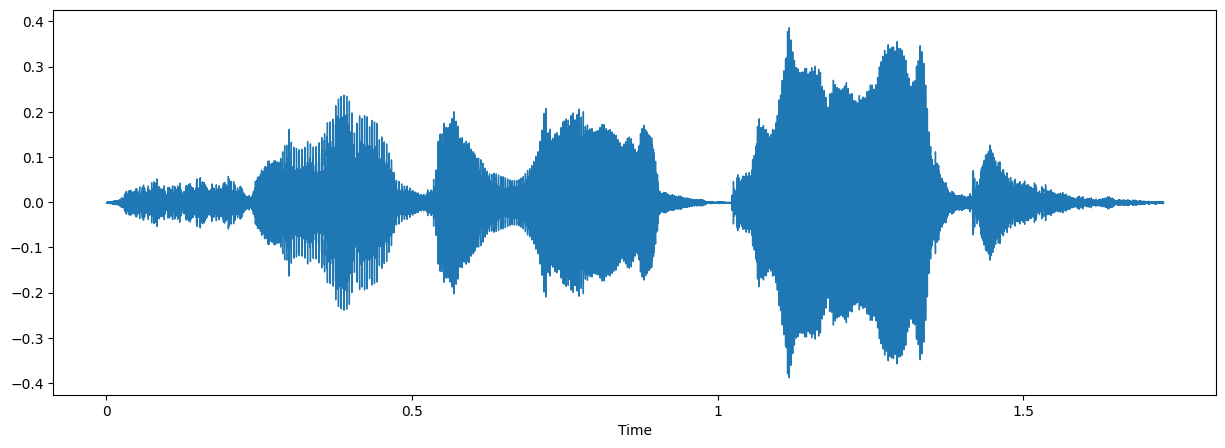

In [11]:
fname ="D:\data\Tess\YAF_fear\YAF_dog_fear.wav" 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

In [12]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:5])



['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav']


In [13]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(os.path.join(CREMA, i))
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_disgust      673
male_fear         673
male_happy        673
male_angry        672
male_sad          672
female_disgust    605
female_angry      601
female_fear       601
female_happy      601
female_sad        601
male_neutral      577
female_neutral    513
Name: labels, dtype: int64

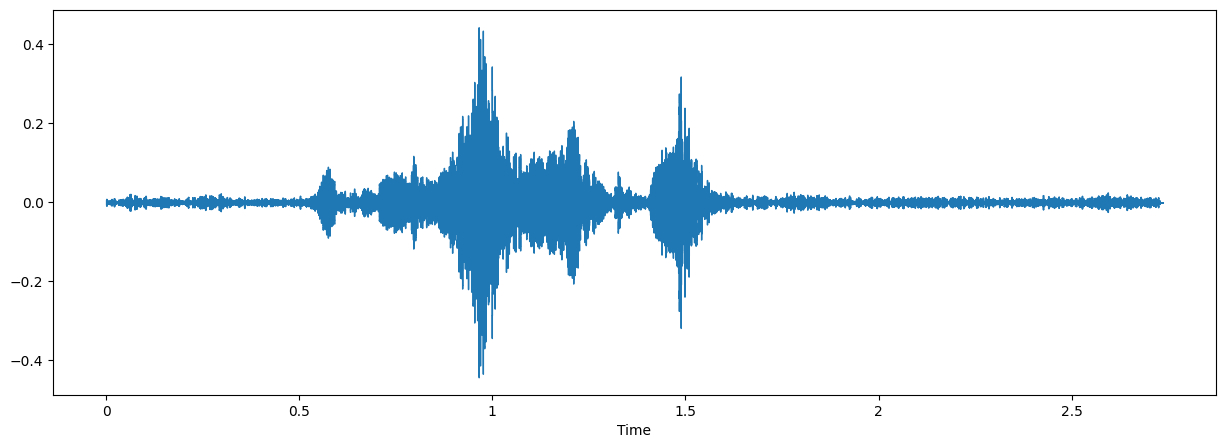

In [14]:
fname =r"D:\data\Crema\1012_IEO_HAP_HI.wav"
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

<h2>Full ONE Data SET<h2>


In [15]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_disgust     1101
female_happy       1097
female_angry       1097
female_fear        1097
female_neutral     1057
female_sad          909
male_neutral        841
male_disgust        829
male_fear           829
male_happy          829
male_angry          828
male_sad            828
female_surprise     296
male_surprise       156
Name: labels, dtype: int64


In [16]:
df

labels source                               path
0         male_angry  SAVEE           D:\data\Savee\DC_a01.wav
1         male_angry  SAVEE           D:\data\Savee\DC_a02.wav
2         male_angry  SAVEE           D:\data\Savee\DC_a03.wav
3         male_angry  SAVEE           D:\data\Savee\DC_a04.wav
4         male_angry  SAVEE           D:\data\Savee\DC_a05.wav
...              ...    ...                                ...
7457  female_disgust  CREMA  D:\data\Crema\1091_WSI_DIS_XX.wav
7458     female_fear  CREMA  D:\data\Crema\1091_WSI_FEA_XX.wav
7459    female_happy  CREMA  D:\data\Crema\1091_WSI_HAP_XX.wav
7460  female_neutral  CREMA  D:\data\Crema\1091_WSI_NEU_XX.wav
7461      female_sad  CREMA  D:\data\Crema\1091_WSI_SAD_XX.wav

[11794 rows x 3 columns]

In [17]:
ref = pd.read_csv("Data_path.csv")
ref.head()

labels source                      path
0  male_angry  SAVEE  D:\data\Savee\DC_a01.wav
1  male_angry  SAVEE  D:\data\Savee\DC_a02.wav
2  male_angry  SAVEE  D:\data\Savee\DC_a03.wav
3  male_angry  SAVEE  D:\data\Savee\DC_a04.wav
4  male_angry  SAVEE  D:\data\Savee\DC_a05.wav

In [18]:
ref["labels"].unique()

array(['male_angry', 'male_disgust', 'male_fear', 'male_happy',
       'male_neutral', 'male_sad', 'male_surprise', 'female_neutral',
       'female_happy', 'female_sad', 'female_angry', 'female_fear',
       'female_disgust', 'female_surprise'], dtype=object)

In [19]:
def noise(data):
    """
    Adding White Noise to raw audio data.
    """
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    """
    Random Shifting on raw audio data.
    """
    s_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    """
    Stretching the Sound (time stretch).
    """
    return librosa.effects.time_stretch(data, rate=0.8)
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_change, bins_per_octave=bins_per_octave)
def dyn_change(data):
    """
    Random amplitude change on raw audio.
    """
    dyn_change_factor = np.random.uniform(low=0.5, high=7)
    return data * dyn_change_factor
def speedNpitch(data):
    """
    Speed and Pitch Tuning on raw audio.
    """
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.2 / length_change
    tmp = np.interp(np.arange(0, len(data), speed_fac), np.arange(0, len(data)), data)
    minlen = min(data.shape[0], tmp.shape[0])
    data[:minlen] = tmp[:minlen]
    return data




####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

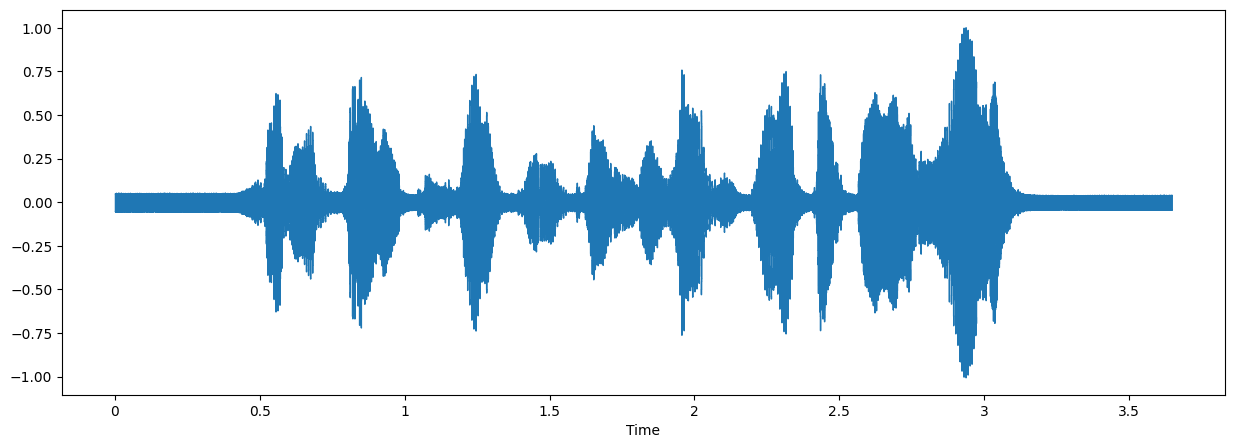

In [20]:
fname = 'D:\data\Savee\DC_a01.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

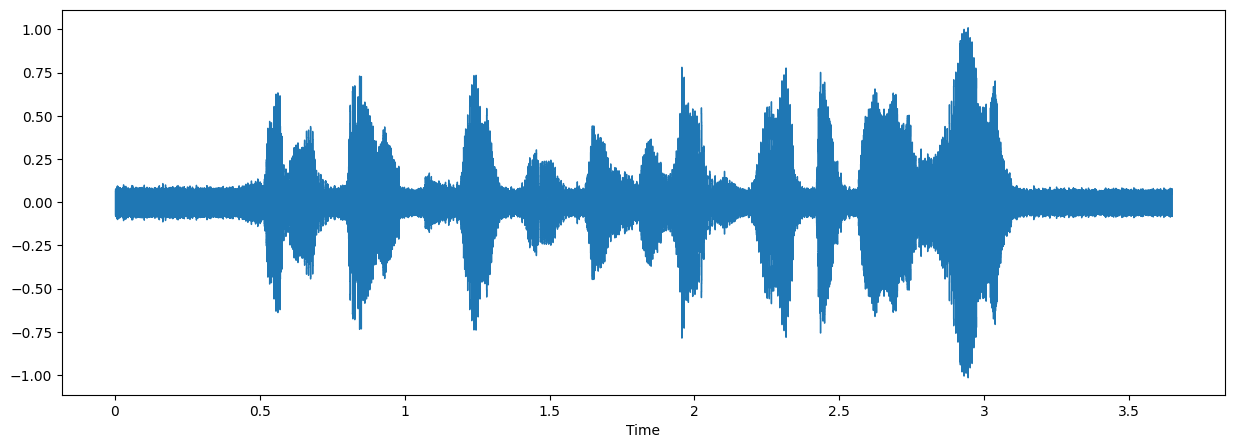

In [21]:
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

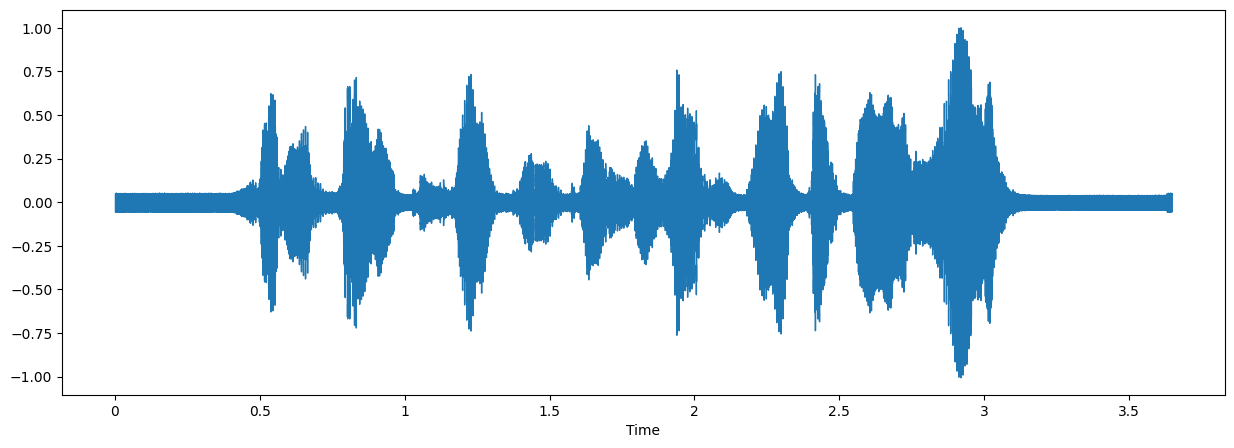

In [22]:

x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

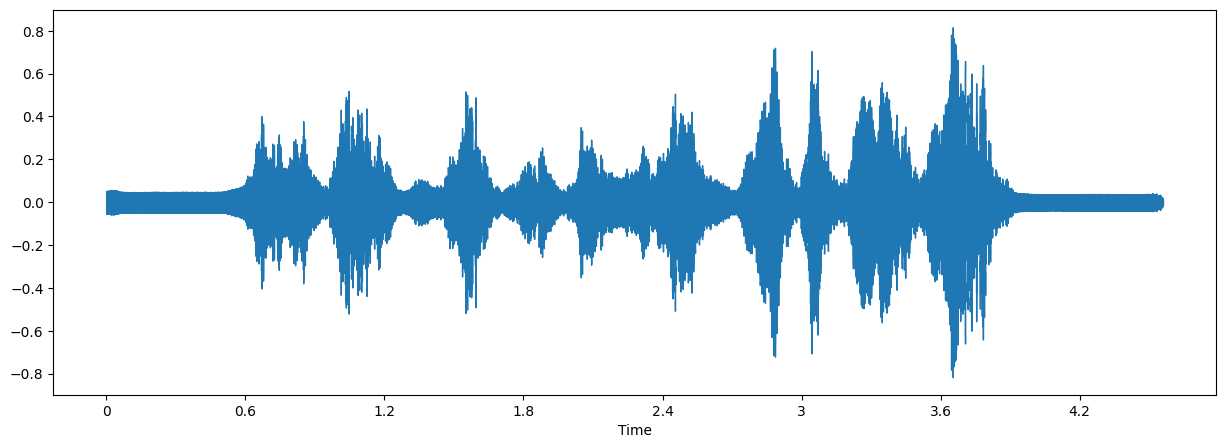

In [23]:
x = stretch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

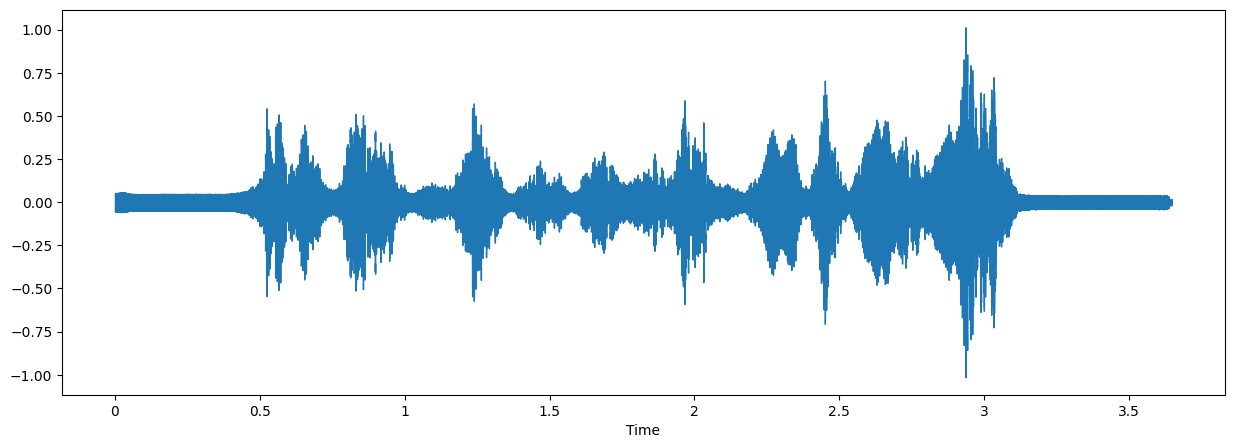

In [24]:
x = pitch(data, sampling_rate)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

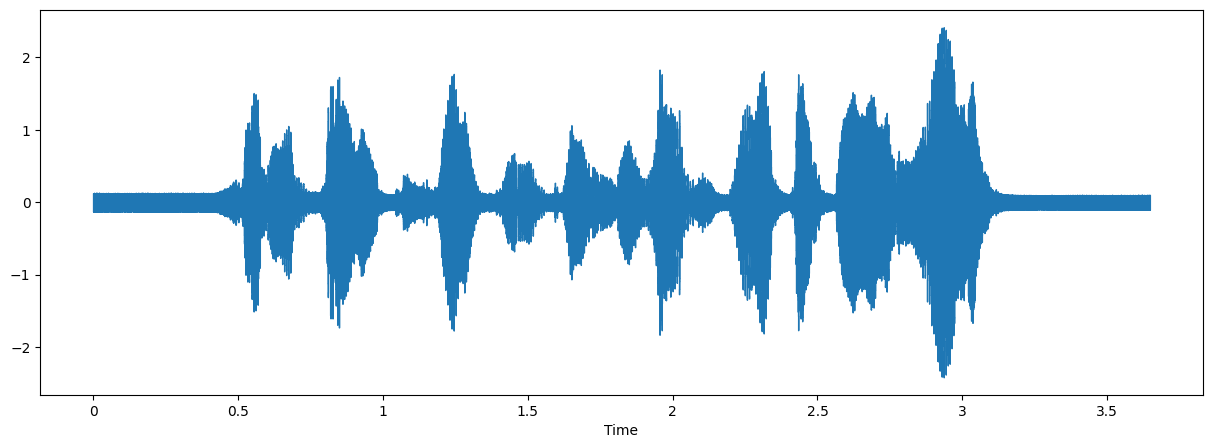

In [25]:
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

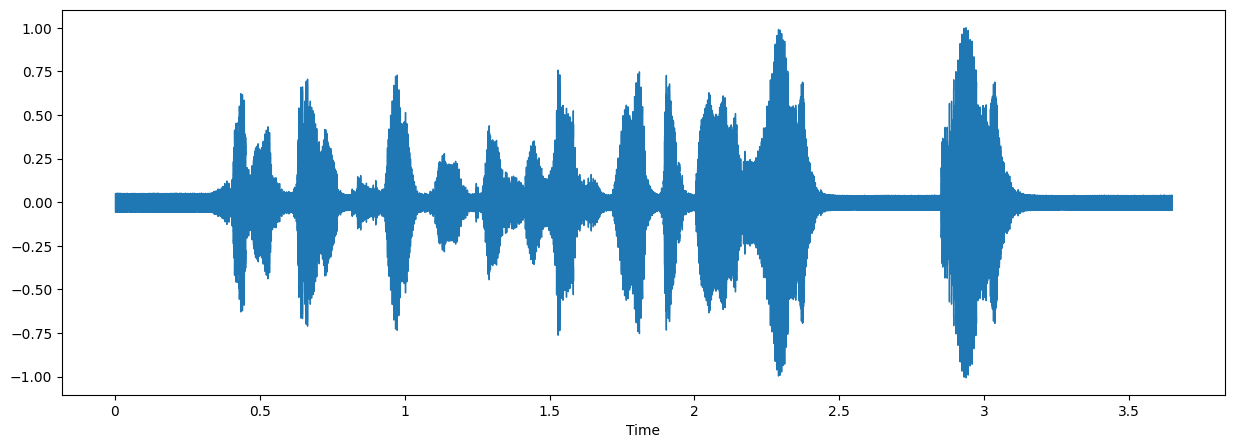

In [26]:
x = speedNpitch(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)


In [28]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import librosa

# DataFrames to store concatenated features
df = pd.DataFrame(columns=['mfcc_features', 'mel_features', 'chroma_features'])
df_noise = pd.DataFrame(columns=['mfcc_noise_features', 'mel_noise_features', 'chroma_noise_features'])
df_speedpitch = pd.DataFrame(columns=['mfcc_speedpitch_features', 'mel_speedpitch_features', 'chroma_speedpitch_features'])
cnt = 0

# Set a fixed size for the features (height, width)
FIXED_HEIGHT = 30   # Number of MFCC coefficients (usually 13)
FIXED_WIDTH = 216   # Fixed width based on average duration and sampling rate

# Function to pad/truncate features to a fixed size
def pad_or_truncate(feature, height=FIXED_HEIGHT, width=FIXED_WIDTH):
    if feature.shape[0] > height:
        feature = feature[:height, :]
    elif feature.shape[0] < height:
        padding = height - feature.shape[0]
        feature = np.pad(feature, ((0, padding), (0, 0)), mode='constant')

    if feature.shape[1] > width:
        feature = feature[:, :width]
    elif feature.shape[1] < width:
        padding = width - feature.shape[1]
        feature = np.pad(feature, ((0, 0), (0, padding)), mode='constant')
    
    return feature

# Define functions for noise and speed/pitch augmentation
def noise(y, noise_level=0.005):
    noise = np.random.randn(len(y))
    y = y + noise_level * noise
    return y

def speedNpitch(y, speed_rate=1.2, pitch_shift=2):
    y_speed = librosa.effects.time_stretch(y, rate=speed_rate)  
    y_pitch = librosa.effects.pitch_shift(y_speed, sr=44100, n_steps=pitch_shift)
    return y_pitch

# Feature extraction loop over the dataset
for i in tqdm(ref.path):
    
    # Load the audio file
    X, sample_rate = librosa.load(i, 
                                  res_type='kaiser_fast', 
                                  duration=2.5, 
                                  sr=44100, 
                                  offset=0.5)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=30)
    mfcc_db = librosa.power_to_db(mfcc, ref=np.max)
    mfcc_db = pad_or_truncate(mfcc_db)
    mfcc_db_flattened = mfcc_db.flatten()

    # Extract Mel Spectrogram features
    mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=30)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = pad_or_truncate(mel_db)
    mel_db_flattened = mel_db.flatten()

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    chroma_db = pad_or_truncate(chroma)
    chroma_db_flattened = chroma_db.flatten()

    # Store in DataFrame
    df.loc[cnt] = [mfcc_db_flattened, mel_db_flattened, chroma_db_flattened]

    # Apply noise augmentation
    aug_noise = noise(X)
    mfcc_noise = librosa.feature.mfcc(y=aug_noise, sr=sample_rate, n_mfcc=30)
    mfcc_noise_db = librosa.power_to_db(mfcc_noise, ref=np.max)
    mfcc_noise_db = pad_or_truncate(mfcc_noise_db)
    mfcc_noise_flattened = mfcc_noise_db.flatten()

    mel_noise = librosa.feature.melspectrogram(y=aug_noise, sr=sample_rate, n_mels=30)
    mel_noise_db = librosa.power_to_db(mel_noise, ref=np.max)
    mel_noise_db = pad_or_truncate(mel_noise_db)
    mel_noise_flattened = mel_noise_db.flatten()

    chroma_noise = librosa.feature.chroma_stft(y=aug_noise, sr=sample_rate)
    chroma_noise_db = pad_or_truncate(chroma_noise)
    chroma_noise_flattened = chroma_noise_db.flatten()

    df_noise.loc[cnt] = [mfcc_noise_flattened, mel_noise_flattened, chroma_noise_flattened]

    # Apply speed and pitch augmentation
    aug_speedpitch = speedNpitch(X)
    mfcc_speedpitch = librosa.feature.mfcc(y=aug_speedpitch, sr=sample_rate, n_mfcc=30)
    mfcc_speedpitch_db = librosa.power_to_db(mfcc_speedpitch, ref=np.max)
    mfcc_speedpitch_db = pad_or_truncate(mfcc_speedpitch_db)
    mfcc_speedpitch_flattened = mfcc_speedpitch_db.flatten()

    mel_speedpitch = librosa.feature.melspectrogram(y=aug_speedpitch, sr=sample_rate, n_mels=30)
    mel_speedpitch_db = librosa.power_to_db(mel_speedpitch, ref=np.max)
    mel_speedpitch_db = pad_or_truncate(mel_speedpitch_db)
    mel_speedpitch_flattened = mel_speedpitch_db.flatten()

    chroma_speedpitch = librosa.feature.chroma_stft(y=aug_speedpitch, sr=sample_rate)
    chroma_speedpitch_db = pad_or_truncate(chroma_speedpitch)
    chroma_speedpitch_flattened = chroma_speedpitch_db.flatten()

    df_speedpitch.loc[cnt] = [mfcc_speedpitch_flattened, mel_speedpitch_flattened, chroma_speedpitch_flattened]

    # Increment counter
    cnt += 1


100%|██████████████████████████████████████████████████████████████████████████| 11794/11794 [1:34:07<00:00,  2.09it/s]


In [29]:

# Convert MFCC, Mel, and Chroma features to float32
df_mfcc = pd.DataFrame(df['mfcc_features'].tolist()).astype(np.float32)
df_mel = pd.DataFrame(df['mel_features'].tolist()).astype(np.float32)
df_chroma = pd.DataFrame(df['chroma_features'].tolist()).astype(np.float32)

# For noise-augmented data
df_noise_mfcc = pd.DataFrame(df_noise['mfcc_noise_features'].tolist()).astype(np.float32)
df_noise_mel = pd.DataFrame(df_noise['mel_noise_features'].tolist()).astype(np.float32)
df_noise_chroma = pd.DataFrame(df_noise['chroma_noise_features'].tolist()).astype(np.float32)

# For speed/pitch-augmented data
df_speedpitch_mfcc = pd.DataFrame(df_speedpitch['mfcc_speedpitch_features'].tolist()).astype(np.float32)
df_speedpitch_mel = pd.DataFrame(df_speedpitch['mel_speedpitch_features'].tolist()).astype(np.float32)
df_speedpitch_chroma = pd.DataFrame(df_speedpitch['chroma_speedpitch_features'].tolist()).astype(np.float32)

# Verify the data types
print(df_mfcc.dtypes)
print(df_noise_mfcc.dtypes)
print(df_speedpitch_mfcc.dtypes)

# Ensure the DataFrames have the same shape before concatenating with `ref`
df = pd.concat([ref, df_mfcc, df_mel, df_chroma], axis=1)
df_noise = pd.concat([ref, df_noise_mfcc, df_noise_mel, df_noise_chroma], axis=1)
df_speedpitch = pd.concat([ref, df_speedpitch_mfcc, df_speedpitch_mel, df_speedpitch_chroma], axis=1)

# Print the shapes of the combined DataFrames
print(df.shape, df_noise.shape, df_speedpitch.shape)

0       float32
1       float32
2       float32
3       float32
4       float32
         ...   
6475    float32
6476    float32
6477    float32
6478    float32
6479    float32
Length: 6480, dtype: object
0       float32
1       float32
2       float32
3       float32
4       float32
         ...   
6475    float32
6476    float32
6477    float32
6478    float32
6479    float32
Length: 6480, dtype: object
0       float32
1       float32
2       float32
3       float32
4       float32
         ...   
6475    float32
6476    float32
6477    float32
6478    float32
6479    float32
Length: 6480, dtype: object
(11794, 19443) (11794, 19443) (11794, 19443)


In [30]:
df.isnull().sum()

labels    0
source    0
path      0
0         0
1         0
         ..
6475      0
6476      0
6477      0
6478      0
6479      0
Length: 19443, dtype: int64

In [31]:
# Save intermediate DataFrames to CSV
df.to_csv('df.csv', index=False)
df_noise.to_csv('df_noise.csv', index=False)
df_speedpitch.to_csv('df_speedpitch.csv', index=False)

# Read them back when needed and concatenate
df = pd.read_csv('df.csv')
df_noise = pd.read_csv('df_noise.csv')
df_speedpitch = pd.read_csv('df_speedpitch.csv')

df = pd.concat([df, df_noise, df_speedpitch], axis=0)


In [32]:
 del df_noise, df_speedpitch
print(df.shape)
df["labels"].unique()
# Define the values you want to remove
values_to_remove = ['1', '2', '3', '4', '5', '6', '7', '8']

# Use isin() to drop rows where the "labels" column contains any of these values
df = df[~df["labels"].isin(values_to_remove)]

# Check the "labels" column
df["labels"]
df["labels"].unique()


(35382, 19443)


array(['male_angry', 'male_disgust', 'male_fear', 'male_happy',
       'male_neutral', 'male_sad', 'male_surprise', 'female_neutral',
       'female_happy', 'female_sad', 'female_angry', 'female_fear',
       'female_disgust', 'female_surprise'], dtype=object)

In [33]:
df.isnull().sum()
df

labels source                               path     0     1  \
0          male_angry  SAVEE           D:\data\Savee\DC_a01.wav -80.0 -80.0   
1          male_angry  SAVEE           D:\data\Savee\DC_a02.wav -80.0 -80.0   
2          male_angry  SAVEE           D:\data\Savee\DC_a03.wav -80.0 -80.0   
3          male_angry  SAVEE           D:\data\Savee\DC_a04.wav -80.0 -80.0   
4          male_angry  SAVEE           D:\data\Savee\DC_a05.wav -80.0 -80.0   
...               ...    ...                                ...   ...   ...   
11789  female_disgust  CREMA  D:\data\Crema\1091_WSI_DIS_XX.wav -80.0 -80.0   
11790     female_fear  CREMA  D:\data\Crema\1091_WSI_FEA_XX.wav -80.0 -80.0   
11791    female_happy  CREMA  D:\data\Crema\1091_WSI_HAP_XX.wav -80.0 -80.0   
11792  female_neutral  CREMA  D:\data\Crema\1091_WSI_NEU_XX.wav -80.0 -80.0   
11793      female_sad  CREMA  D:\data\Crema\1091_WSI_SAD_XX.wav -80.0 -80.0   

          2     3     4     5     6  ...  6470.2  6471.2  6472.2  6473.2  \
0     -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
1     -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
2     -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
3     -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
4     -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
...     ...   ...   ...   ...   ...  ...     ...     ...     ...     ...   
11789 -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
11790 -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
11791 -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
11792 -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   
11793 -80.0 -80.0 -80.0 -80.0 -80.0  ...     0.0     0.0     0.0     0.0   

       6474.2  6475.2  6476.2  6477.2  6478.2  6479.2  
0         0.0     0.0     0.0     0.0     0.0     0.0  
1         0.0     0.0     0.0     0.0     0.0     0.0  
2         0.0     0.0     0.0     0.0     0.0     0.0  
3         0.0     0.0     0.0     0.0     0.0     0.0  
4         0.0     0.0     0.0     0.0     0.0     0.0  
...       ...     ...     ...     ...     ...     ...  
11789     0.0     0.0     0.0     0.0     0.0     0.0  
11790     0.0     0.0     0.0     0.0     0.0     0.0  
11791     0.0     0.0     0.0     0.0     0.0     0.0  
11792     0.0     0.0     0.0     0.0     0.0     0.0  
11793     0.0     0.0     0.0     0.0     0.0     0.0  

[35382 rows x 19443 columns]

In [34]:

print(df["labels"].value_counts())

female_disgust     3303
female_happy       3291
female_angry       3291
female_fear        3291
female_neutral     3171
female_sad         2727
male_neutral       2523
male_disgust       2487
male_fear          2487
male_happy         2487
male_angry         2484
male_sad           2484
female_surprise     888
male_surprise       468
Name: labels, dtype: int64


In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Assuming df is your DataFrame containing the data
# Convert to float32 to reduce memory usage
X = df.drop(['path', 'labels', 'source'], axis=1)
y = df['labels'] 

# Convert multilabel target into a binary format

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

# Convert the data to float32 early on to save memory
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Parameters for Conv2D input
height = 90   # Adjusted height
width = 216   # Number of columns (fixed)
channels = 1  # Single channel for Conv2D (e.g., grayscale)

# Verify dimensions match the number of features in X_train_resampled
assert height * width == X_train.shape[1], f"Height * Width ({height * width}) does not match the number of features in X_train_resampled ({X_train_resampled.shape[1]})."

# Reshape the resampled training data and test data for Conv2D input (batch, height, width, channels)
X_train_reshaped = X_train.reshape(-1, height, width, channels)
X_test_reshaped = X_test.reshape(-1, height, width, channels)

# Verify reshaped dimensions
print("X_train reshaped:", X_train_reshaped.shape)
print("X_test reshaped:", X_test_reshaped.shape)


# Print a sample of reshaped data for verification
print("Sample data from X_train:", X_train_reshaped[150:160])


MemoryError: Unable to allocate 5.12 GiB for an array with shape (19440, 35382) and data type float64

In [ ]:
import pickle 
if y_train.ndim > 1:
    y_train = np.argmax(y_train, axis=1)
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

# One-hot encode the target labels
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

# Check the shapes of the processed data
print(f"X_train shape: {X_train_reshaped.shape}")  # Expected shape: (samples, height, width, channels)
print(f"y_train shape: {y_train.shape}") 
print(f"X_test shape: {X_test_reshaped.shape}")
print(f"y_test shape: {y_test.shape}")
print("Classes:", lb.classes_)

# Pickle the LabelEncoder object for future use
filename = 'labels.pkl'  # Add .pkl extension for clarity
with open(filename, 'wb') as outfile:
    pickle.dump(lb, outfile)

print("LabelEncoder object has been saved.")


In [ ]:
from keras.regularizers import l2


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape
from keras.regularizers import l2
from keras.optimizers import Adam

# Model architecture
model = Sequential()

# First Conv2D layer with L2 regularization and Batch Normalization
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(90, 216, 1), kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Conv2D layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Conv2D layer with more filters
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Conv2D layer
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 2)))

# Reshape the 2D output into a sequence for LSTM layer
model.add(Reshape((11, 13 * 512)))  # Adjust dimensions based on pooling output (11x13x512 -> 11x6656)

# Adding LSTM layer for capturing temporal patterns
model.add(LSTM(128, return_sequences=False))  # LSTM layer to capture sequential dependencies

# Fully connected Dense layer
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model.add(Dense(14, activation='softmax'))

# Compile the model with Adam optimizer and lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()



In [ ]:
print("X_train_reshaped shape:", X_train_reshaped.shape)  # Should match with y_train_resampled.shape[0]
print("y_train_resampled shape:", y_train_resampled.shape)  # Should match with X_train_reshaped.shape[0]


In [ ]:
# After reshaping, use the resampled labels
print("Shape before fitting:")
print("X_train_reshaped shape:", X_train_reshaped.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

# Ensure you are using the resampled labels
model_history = model.fit(X_train_reshaped, y_train,  # Changed to y_train_resampled
                          batch_size=16, 
                          epochs=30, 
                          validation_data=(X_test_reshaped, y_test), 
                          verbose=2,
                          callbacks=[early_stopping, reduce_lr])


In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test accuracy: {accuracy:.2f}')

In [ ]:
preds = model.predict(X_test_reshaped, 
                         batch_size=64, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

In [ ]:
import seaborn  as sns 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
model_path = "./res_model.h5"

model.save(model_path)

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))
